In [ ]:
!unzip dataset.zip

In [374]:
import tensorflow as tf
import os
import pandas as pd
import shutil
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint


In [119]:
# mobilenet weights
tf.keras.applications.MobileNet(input_shape=(224,224,3),

                                ).save('mobile.h5')

In [120]:
print(f'Model Size: {round(os.path.getsize("mobile.h5")/1024**2, 3)}MB')

Model Size: 16.476MB


In [117]:
base_model = tf.keras.applications.MobileNet(input_shape=(96,96,3),
                                weights='/content/MobileNetV1.0_2.96x96.color.bsize_96.lr_0_05.epoch_170.val_loss_3.61.val_accuracy_0.27.hdf5',
                                alpha=0.2
                                )

base_model.trainable = False

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(96,96,3), name='x_input'))
# Don't include the base model's top layers
last_layer_index = -5
model.add(tf.keras.Model(inputs=base_model.inputs, outputs=base_model.layers[last_layer_index].output))
model.add(tf.keras.layers.Reshape((-1, model.layers[-1].output.shape[3])))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(6, activation='relu'))


17225924/17225924 [==============================] - 0s 0us/step


In [104]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_8 (Functional)        (None, 1, 1, 204)         142259    
                                                                 
 reshape_8 (Reshape)         (None, 1, 204)            0         
                                                                 
 dropout_8 (Dropout)         (None, 1, 204)            0         
                                                                 
 flatten_8 (Flatten)         (None, 204)               0         
                                                                 
 dense_8 (Dense)             (None, 6)                 1230      
                                                                 
Total params: 143,489
Trainable params: 1,230
Non-trainable params: 142,259
_________________________________________________________________


In [ ]:
# rearrange the format of the data
def split_data(image_dir, label_df, value):
    '''
    value - the type either test or train
    label_df - the dataframe containing the labels of the classes
    image_dir - the directory containing the images
    '''
    for ind, row in label_df.iterrows():
        print(row['Species'])
        if os.path.exists(f'{value}') is False:
            os.mkdir(f'{value}')
        else:
            if os.path.exists(f'{value}/{row["Species"]}') is False:
                os.mkdir(f'{value}/{row["Species"]}')
                shutil.copy(f'{image_dir}/{row["filename"]}', f'{value}/{row["Species"]}')
            else:
                shutil.copy(f'{image_dir}/{row["filename"]}', f'{value}/{row["Species"]}')


In [ ]:
base_path = '/content/dataset'
train_path = os.path.join(base_path, 'train')
test_path = os.path.join(base_path, 'test')

# load the test and train metadata
test_df = pd.read_csv(os.path.join(base_path, 'test.csv'))
train_df = pd.read_csv(os.path.join(base_path, 'train.csv'))

# split data
# # train and test data

split_data(train_path, train_df, 'train')
split_data(test_path, test_df, 'test')


In [140]:
n_train_dir = 'train'
n_test_dir = 'test'
seed = 2023

train_dataset = tf.keras.utils.image_dataset_from_directory(
    n_train_dir,
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
)

# Extract the train images and labels
train_images = []
train_labels = []

for images, labels in train_dataset:
    train_images.append(images.numpy()[0])
    train_labels.append(labels.numpy()[0])

train_images = np.array(train_images)
train_labels = np.array(train_labels)

# Load the dataset again, this time for testing/validation
test_dataset = tf.keras.utils.image_dataset_from_directory(
    n_test_dir,
    batch_size=32,
    image_size=(224, 224)
)

# Extract the test images and labels
test_images = []
test_labels = []

for images, labels in test_dataset:
    test_images.append(images.numpy()[0])
    test_labels.append(labels.numpy()[0])

test_images = np.array(test_images)
test_labels = np.array(test_labels)

# normalizing the values
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0

# one hot encoding the labels
# test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=6)
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=6)

Found 2085 files belonging to 6 classes.
Found 235 files belonging to 6 classes.


In [ ]:
BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 0.0005
# train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=False)
# validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=False)
# callbacks.append(BatchLoggerCallback(BATCH_SIZE, train_sample_count, epochs=EPOCHS))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# train_dataset = train_dataset.map(lambda x, y: (x, tf.keras.utils.to_categorical(y, num_classes=6)))
# model.fit(train_dataset, epochs=EPOCHS, verbose=2)
model.fit(
  train_images,
  train_labels,
  epochs=30,
  validation_data=(test_images, test_labels),
  verbose=2
)

In [114]:
model.evaluate(test_images, test_labels)

1/1 [==============================] - 0s 47ms/step - loss: nan - accuracy: 0.2500


[nan, 0.25]

VEry poor accuracy model not learning

In [131]:
y = model.evaluate(test_images, test_labels)
y

1/1 [==============================] - 1s 523ms/step - loss: nan - accuracy: 0.1250


[nan, 0.125]

In [141]:
from sklearn.metrics import classification_report

y_pred = model.predict(test_images, batch_size=32, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(test_labels, y_pred_bool))

1/1 [==============================] - 0s 274ms/step
              precision    recall  f1-score   support

           0       0.12      1.00      0.22         1
           1       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         2

    accuracy                           0.12         8
   macro avg       0.03      0.25      0.06         8
weighted avg       0.02      0.12      0.03         8



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [242]:
train_df.Species.value_counts(normalize=True)

IMPALA       0.390221
WARTHOG      0.280441
WATERBUCK    0.155801
BUSHBUCK     0.088207
ZEBRA        0.074784
MONKEY       0.010547
Name: Species, dtype: float64

In [243]:
train_df[train_df['Species'] != 'IMPALA'].Species.value_counts(normalize=True)

WARTHOG      0.459906
WATERBUCK    0.255503
BUSHBUCK     0.144654
ZEBRA        0.122642
MONKEY       0.017296
Name: Species, dtype: float64

In [244]:
train_df[(train_df['Species'] != 'MONKEY') & (train_df['Species'] != 'ZEBRA')].Species.value_counts(normalize=True)

IMPALA       0.426625
WARTHOG      0.306604
WATERBUCK    0.170335
BUSHBUCK     0.096436
Name: Species, dtype: float64

In [245]:
train_df[(train_df['Species'] != 'MONKEY') & (train_df['Species'] != 'ZEBRA') & (train_df['Species'] != 'BUSHBUCK')].Species.value_counts(normalize=True)

IMPALA       0.472158
WARTHOG      0.339327
WATERBUCK    0.188515
Name: Species, dtype: float64

In [246]:
train_df[(train_df['Species'] == 'MONKEY') | (train_df['Species'] == 'ZEBRA') | (train_df['Species'] == 'BUSHBUCK')].Species.value_counts(normalize=True)

BUSHBUCK    0.508287
ZEBRA       0.430939
MONKEY      0.060773
Name: Species, dtype: float64

In [236]:
others = ['MONKEY', 'ZEBRA', 'BUSHBUCK']
# if any of the speceies replace with others
def replace_with_others(x):
  if x in others:
    return 'OTHERS'
  else:
    return x

<Axes: >

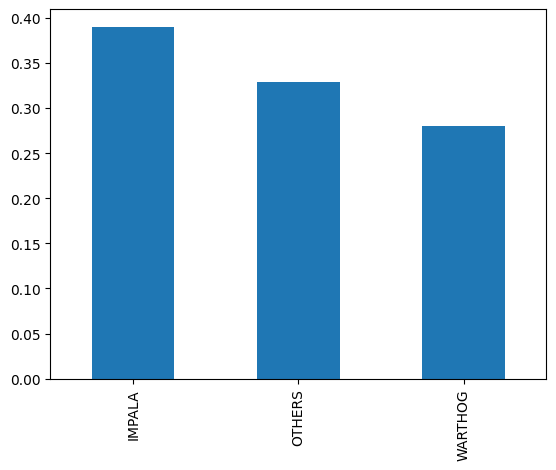

In [235]:
train_df.Species.apply(replace_with_others).value_counts(normalize=True).plot(kind='bar')

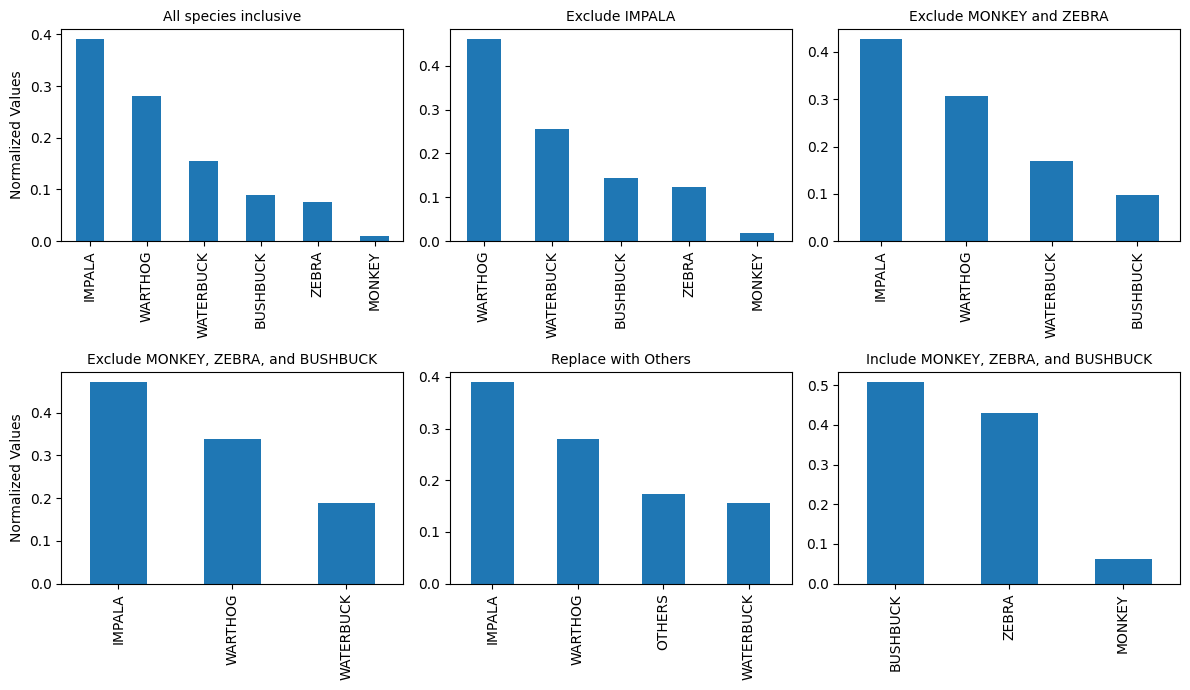

In [254]:
plt.figure(figsize=(12, 7))

# Plot 1
plt.subplot(231)
train_df.Species.value_counts(normalize=True).plot(kind='bar')
plt.title('All species inclusive', fontdict={'fontsize': 10})
plt.ylabel('Normalized Values')


# Plot 2
plt.subplot(232)
train_df[train_df['Species'] != 'IMPALA'].Species.value_counts(normalize=True).plot(kind='bar')
plt.title('Exclude IMPALA', fontdict={'fontsize': 10})

# Plot 3
plt.subplot(233)
train_df[(train_df['Species'] != 'MONKEY') & (train_df['Species'] != 'ZEBRA')].Species.value_counts(normalize=True).plot(kind='bar')
plt.title('Exclude MONKEY and ZEBRA', fontdict={'fontsize': 10})

# Plot 4
plt.subplot(234)
train_df[(train_df['Species'] != 'MONKEY') & (train_df['Species'] != 'ZEBRA') & (train_df['Species'] != 'BUSHBUCK')].Species.value_counts(normalize=True).plot(kind='bar')
plt.title('Exclude MONKEY, ZEBRA, and BUSHBUCK', fontdict={'fontsize': 10})
plt.ylabel('Normalized Values')


# Plot 5
plt.subplot(235)
train_df.Species.apply(replace_with_others).value_counts(normalize=True).plot(kind='bar')
plt.title('Replace with Others', fontdict={'fontsize': 10})

# Plot 6
plt.subplot(236)
train_df[(train_df['Species'] == 'MONKEY') | (train_df['Species'] == 'ZEBRA') | (train_df['Species'] == 'BUSHBUCK')].Species.value_counts(normalize=True).plot(kind='bar')
plt.title('Include MONKEY, ZEBRA, and BUSHBUCK', fontdict={'fontsize': 10})

# Add x-label
# plt.ylabel('Normalized Values')


# Adjust spacing between subplots
plt.tight_layout()

# save the figure
plt.savefig('class_distribution.png', dpi=500)

# Show the combined plot
plt.show()


In [262]:
train_df['Species'] = train_df.Species.apply(replace_with_others)

In [265]:
test_df.Species = test_df.Species.apply(replace_with_others)

In [ ]:
split_data(train_path, train_df, 'train2')
split_data(test_path, test_df, 'test2')


In [353]:
n_train_dir = 'train2'
n_test_dir = 'test2'
seed = 2023

train_dataset = tf.keras.utils.image_dataset_from_directory(
    n_train_dir,
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
)

# Extract the train images and labels
train_images = []
train_labels = []

for images, labels in train_dataset:
    train_images.append(images.numpy()[0])
    train_labels.append(labels.numpy()[0])

train_images = np.array(train_images)
train_labels = np.array(train_labels)

# Load the dataset again, this time for testing/validation
test_dataset = tf.keras.utils.image_dataset_from_directory(
    n_test_dir,
    batch_size=32,
    image_size=(224, 224)
)

# Extract the test images and labels
test_images = []
test_labels = []

for images, labels in test_dataset:
    test_images.append(images.numpy()[0])
    test_labels.append(labels.numpy()[0])

test_images = np.array(test_images)
test_labels = np.array(test_labels)

# normalizing the values
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0

# one hot encoding the labels
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=4)
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=4)

Found 2085 files belonging to 4 classes.
Found 235 files belonging to 4 classes.


In [375]:
base_model = tf.keras.applications.MobileNet(input_shape=(224, 224, 3), include_top=False)

base_model.trainable = False

model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(4, activation='softmax'))



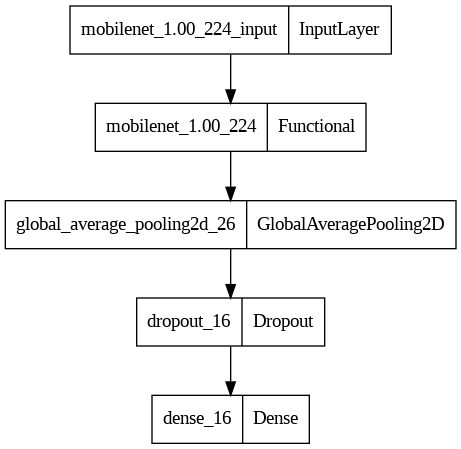

In [295]:
plot_model(model)

In [298]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_29  (None, 1024)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_17 (Dropout)        (None, 1024)              0         
                                                                 
 dense_17 (Dense)            (None, 6)                 6150      
                                                                 
Total params: 3,235,014
Trainable params: 6,150
Non-trainable params: 3,228,864
_________________________________________________________________


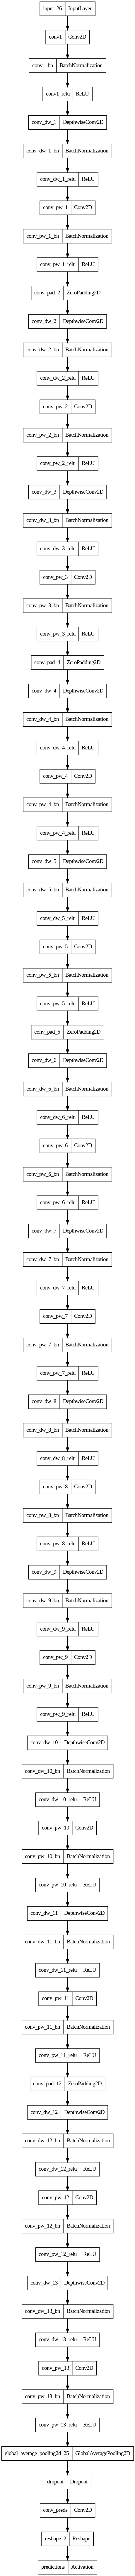

In [293]:
plot_model(base_model)

In [284]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_13 (Functional)       (None, 1, 1, 1024)        3228864   
                                                                 
 reshape_13 (Reshape)        (None, 1, 1024)           0         
                                                                 
 dropout_14 (Dropout)        (None, 1, 1024)           0         
                                                                 
 flatten_14 (Flatten)        (None, 1024)              0         
                                                                 
 dense_14 (Dense)            (None, 6)                 6150      
                                                                 
Total params: 3,235,014
Trainable params: 6,150
Non-trainable params: 3,228,864
_________________________________________________________________


In [350]:
model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_31  (None, 1024)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_19 (Dropout)        (None, 1024)              0         
                                                                 
 dense_23 (Dense)            (None, 4)                 4100      
                                                                 
Total params: 3,232,964
Trainable params: 4,100
Non-trainable params: 3,228,864
_________________________________________________________________


In [ ]:
BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 0.0005
# train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=False)
# validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=False)
# callbacks.append(BatchLoggerCallback(BATCH_SIZE, train_sample_count, epochs=EPOCHS))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Define the filepath to save the model
filepath = 'best_model.h5'

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max', verbose=2)

# train_dataset = train_dataset.map(lambda x, y: (x, tf.keras.utils.to_categorical(y, num_classes=6)))
# model.fit(train_dataset, epochs=EPOCHS, verbose=2)
# Run model.fit() and store the training history
history = model.fit(
                  train_images,
                  train_labels,
                  epochs=100,
                  validation_data=(test_images, test_labels),
                  verbose=2,
                  callbacks=[checkpoint]
                )

# Retrieve the loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

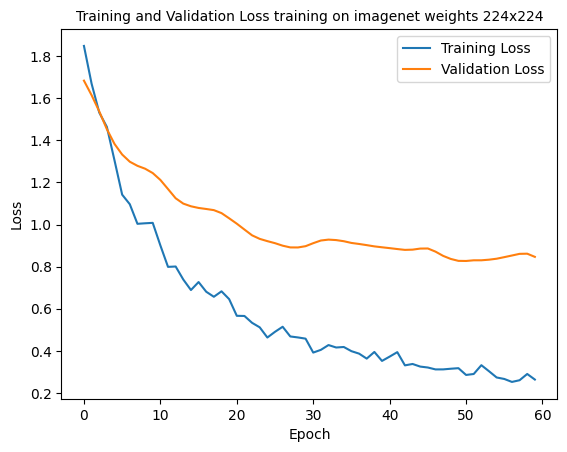

In [370]:
# Retrieve the loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss training on imagenet weights 224x224', fontdict={'fontsize': 10})
plt.legend()

plt.savefig('Losses.png', dpi=500)
plt.show()

In [309]:
model.evaluate(test_images, test_labels)

1/1 [==============================] - 0s 289ms/step - loss: 0.7582 - accuracy: 0.7500


[0.7582066655158997, 0.75]

In [320]:
import warnings
warnings.simplefilter("ignore")
y_pred = model.predict(test_images, batch_size=32, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(test_labels, y_pred_bool))

1/1 [==============================] - 0s 414ms/step
              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.00      0.00      0.00         0
           3       1.00      1.00      1.00         2

    accuracy                           0.88         8
   macro avg       0.67      0.61      0.64         8
weighted avg       1.00      0.88      0.93         8



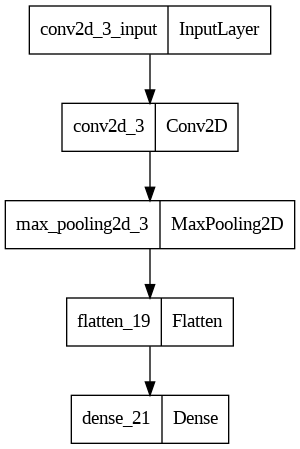

In [304]:
plot_model(model)

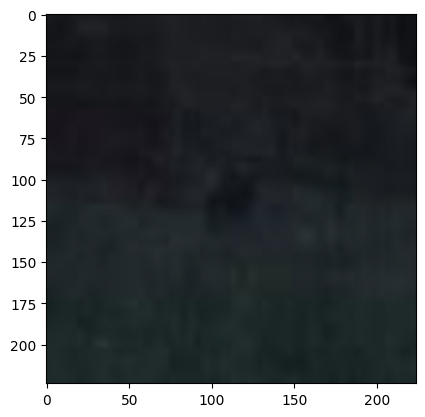

In [334]:
import cv2
img = cv2.imread('/content/test2/WARTHOG/2021-12-09-15-02-37.jpg')
img = cv2.resize(img, (224,224))
img
plt.imshow(img)

In [347]:
mapping= {
    0: 'IMPALA',
    1: 'OTHERS',
    2: 'WARTHOG',
    3: 'WATERBUCK'
}

# Load the image
image = cv2.imread('/content/test2/WARTHOG/2021-12-09-15-02-37.jpg')

# Resize the image to match the input shape of your model
resized_image = cv2.resize(image, (224, 224))

# Preprocess the image
preprocessed_image = np.expand_dims(resized_image, axis=0)
preprocessed_image = preprocessed_image / 255.0  # Normalize the pixel values if required

# Make the prediction
predictions = model.predict(preprocessed_image)
# print(predictions)

# Get the predicted class index
predicted_class_index = np.argmax(predictions, axis=1)
print(max(predictions[0]))

# Print the predicted class index
print(mapping[predicted_class_index[0]])


1/1 [==============================] - 0s 134ms/step
[[0.1037502  0.01786301 0.74055725 0.12476511 0.0086811  0.00438324]]
0.74055725
WARTHOG


1/1 [==============================] - 0s 93ms/step


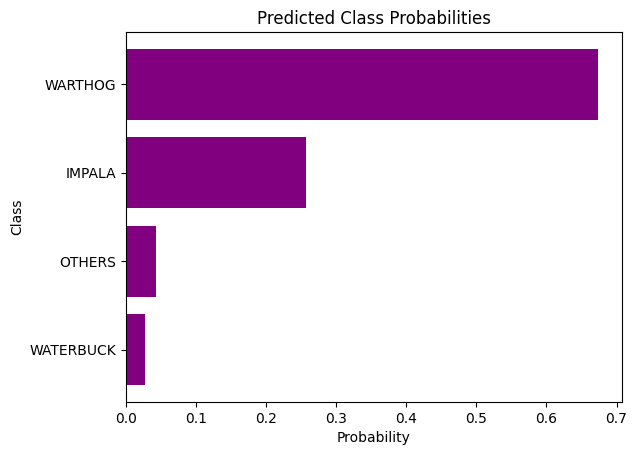

In [372]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

mapping = {
    0: 'IMPALA',
    1: 'OTHERS',
    2: 'WARTHOG',
    3: 'WATERBUCK'
}

# Load the image
image = cv2.imread('/content/test2/WARTHOG/2021-12-09-15-02-37.jpg')

# Resize the image to match the input shape of your model
resized_image = cv2.resize(image, (224, 224))

# Preprocess the image
preprocessed_image = np.expand_dims(resized_image, axis=0)
preprocessed_image = preprocessed_image / 255.0  # Normalize the pixel values if required

# Make the prediction
predictions = model.predict(preprocessed_image)

# Get the predicted class probabilities
predicted_class_probabilities = predictions[0]

# Get the predicted class labels
predicted_class_labels = [mapping[i] for i in range(len(predicted_class_probabilities))]

# Sort the probabilities and labels in descending order
sorted_indices = np.argsort(predicted_class_probabilities)
sorted_probabilities = predicted_class_probabilities[sorted_indices]
sorted_labels = [predicted_class_labels[i] for i in sorted_indices]

# Plot the probabilities as a horizontal bar chart with purple color
plt.barh(sorted_labels, sorted_probabilities, color='purple')
plt.xlabel('Probability')
plt.ylabel('Class')
plt.title('Predicted Class Probabilities')

plt.savefig('predictions.png', dpi=500)
plt.show()


Using Mobilenet weights

In [380]:
n_train_dir = 'train2'
n_test_dir = 'test2'
seed = 2023

train_dataset = tf.keras.utils.image_dataset_from_directory(
    n_train_dir,
    batch_size=32,
    image_size=(96, 96),
    shuffle=True,
)

# Extract the train images and labels
train_images = []
train_labels = []

for images, labels in train_dataset:
    train_images.append(images.numpy()[0])
    train_labels.append(labels.numpy()[0])

train_images = np.array(train_images)
train_labels = np.array(train_labels)

# Load the dataset again, this time for testing/validation
test_dataset = tf.keras.utils.image_dataset_from_directory(
    n_test_dir,
    batch_size=32,
    image_size=(96, 96)
)

# Extract the test images and labels
test_images = []
test_labels = []

for images, labels in test_dataset:
    test_images.append(images.numpy()[0])
    test_labels.append(labels.numpy()[0])

test_images = np.array(test_images)
test_labels = np.array(test_labels)

# normalizing the values
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0

# one hot encoding the labels
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=4)
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=4)





Found 2085 files belonging to 4 classes.
Found 235 files belonging to 4 classes.


In [ ]:
# Define the model with the same architecture as the loaded weights
base_model = tf.keras.applications.MobileNet(input_shape=(96,96,3), include_top=False)

# Load the weights into the base model
base_model.load_weights('/content/MobileNetV1.0_2.96x96.color.bsize_96.lr_0_05.epoch_170.val_loss_3.61.val_accuracy_0.27.hdf5')

# Freeze the base model's layers
base_model.trainable = False

# Create the final model by adding remaining layers on top of the base model
model = tf.keras.Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(4, activation='softmax'))